In [1]:
import pandas as pd
from scipy.stats import norm
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
"""Создаем функцию, которая считает цену фьючерса при различных сценариях.
std-стандартное отклонение цены базового актива"""
def future_change(price,strike,time,r,std):
    vector=[0,0,1/3*std,1/3*std,-1/3*std,-1/3*std,2/3*std,2/3*std,-2/3*std,-2/3*std,std,std,-std,-std,2*std,-2*std]
    changes=[]
    for i in range(0,len(vector)):
        changes.append(price*(1+vector[i])-strike*(math.exp(-time*r)))
    #Два крайних сценария включаются с коэффициентом 0,35
    changes[-1]=changes[-1]*0.35
    changes[-2]=changes[-2]*0.35
    return changes

In [2]:
import math
from scipy.stats import norm
"""Создаем функцию, которая считает цену опциона"""
def option_price_share(price, strike, IV, time, put=False):
    ln=math.log(price/strike)
    denom=IV*math.sqrt(time)
    d1=(((IV**2)/2)*time+ln)/denom
    d2=d1-denom
    
    Nd1=norm.cdf(d1, loc=0, scale=1)
    Nd2=norm.cdf(d2, loc=0, scale=1)
    Nd_1=norm.cdf(-d1, loc=0, scale=1)
    Nd_2=norm.cdf(-d2, loc=0, scale=1)
    option=price*Nd1-strike*Nd2
    if put:
        option=strike*Nd_2-price*Nd_1
    return option

In [3]:
"""Создаем функцию, которая считает цену опциона при различных сценариях
basic_std - ст.откл. цены базового актива
delta_std - ст. откл. изменения IV"""
def option_change(price, strike, IV, time, basic_std, delta_std, put=False):
    price_vector=[0,0,1/3*basic_std,1/3*basic_std,-1/3*basic_std,-1/3*basic_std,
                 2/3*basic_std,2/3*basic_std,-2/3*basic_std,-2/3*basic_std,basic_std,
                 basic_std,-basic_std,-basic_std,2*basic_std,-2*basic_std]
    volatility_vector=[delta_std,-delta_std,delta_std,-delta_std,delta_std,-delta_std,delta_std,-delta_std,
                      delta_std,-delta_std,delta_std,-delta_std,delta_std,-delta_std,0,0]
    PL=[]
    basic_prices=[]
    contract_prices=[]
    if put:
        price0=option_price_share(price, strike, IV, time, put=True)
        for i in range(0,len(price_vector)):
            price_new=option_price_share(price*(1+price_vector[i]), strike, IV+volatility_vector[i], time, put=True)
            basic_prices.append(price*(1+price_vector[i]))
            contract_prices.append(price_new)
            PL.append(price_new-price0)

        PL[-1]=PL[-1]*0.35
        PL[-2]=PL[-2]*0.35

    else:
        price0=option_price_share(price, strike, IV, time, put=False)
        for i in range(0,len(price_vector)):
            price_new=option_price_share(price*(1+price_vector[i]), strike, IV+volatility_vector[i], time, put=False)
            basic_prices.append(price*(1+price_vector[i]))
            contract_prices.append(price_new)
            PL.append(price_new-price0)

        PL[-1]=PL[-1]*0.35
        PL[-2]=PL[-2]*0.35
    return PL, basic_prices, contract_prices

In [4]:
#Задаем вектор объема позиций call_опциона в портфеле на каждый день
#Предполагаем, что можем закрыть позицию только на 7 день
q_c=[2000,2000,2000,2000,2000,2000,0]

In [5]:
#Создадим вектора нереализованных позиций
q_c_risk=[]

for x, y in zip(q_c[0::], q_c[1::]):
        q_c_risk.append(x-y)
q_c_risk.append(0)
q_c_risk

[0, 0, 0, 0, 0, 2000, 0]

In [6]:
#Создаем различные стратегии закрытия форвардных позиций
sale_fut=[]
#Задаем любой вектор из 6 элементов, где 4 элемента равны 500. 
#7 элемент является первым нулевым элементом, т.к. в первый день позиции не закрываются
sale_fut_0=[0,500,500,500,500,0]

#получаем список всех возможных перестановок реализации позиций для 6 элементов
import itertools
per = itertools.permutations(sale_fut_0)
sale_fut_00=[]
for val in per:
    sale_fut_00.append(val)

#Выкидываем повторения
sale_fut_000 = list(set(sale_fut_00))

#Из tuple делаем списки
for i in range(0,len(sale_fut_000)):
    sale_fut.append(list(sale_fut_000[i]))
    
#Добавляем нулевой 7 элемент    
for i in range(0,len(sale_fut)):
    sale_fut[i][:0]=[0]

In [7]:
sale_fut

[[0, 0, 500, 500, 500, 0, 500],
 [0, 500, 0, 0, 500, 500, 500],
 [0, 500, 500, 0, 500, 500, 0],
 [0, 500, 500, 0, 0, 500, 500],
 [0, 0, 500, 500, 0, 500, 500],
 [0, 0, 500, 500, 500, 500, 0],
 [0, 0, 0, 500, 500, 500, 500],
 [0, 500, 0, 500, 500, 0, 500],
 [0, 500, 500, 0, 500, 0, 500],
 [0, 500, 500, 500, 0, 0, 500],
 [0, 500, 0, 500, 500, 500, 0],
 [0, 500, 0, 500, 0, 500, 500],
 [0, 500, 500, 500, 0, 500, 0],
 [0, 0, 500, 0, 500, 500, 500],
 [0, 500, 500, 500, 500, 0, 0]]

In [8]:
#Рассчитываем списки объемов оставшихся позиций в портфеле
for i in range(0,len(sale_fut)):
    q_f=2000
    for j in range(0,len(sale_fut[i])):
        q_f=q_f-sale_fut[i][j]
        sale_fut[i][j]=q_f

In [9]:
sale_fut

[[2000, 2000, 1500, 1000, 500, 500, 0],
 [2000, 1500, 1500, 1500, 1000, 500, 0],
 [2000, 1500, 1000, 1000, 500, 0, 0],
 [2000, 1500, 1000, 1000, 1000, 500, 0],
 [2000, 2000, 1500, 1000, 1000, 500, 0],
 [2000, 2000, 1500, 1000, 500, 0, 0],
 [2000, 2000, 2000, 1500, 1000, 500, 0],
 [2000, 1500, 1500, 1000, 500, 500, 0],
 [2000, 1500, 1000, 1000, 500, 500, 0],
 [2000, 1500, 1000, 500, 500, 500, 0],
 [2000, 1500, 1500, 1000, 500, 0, 0],
 [2000, 1500, 1500, 1000, 1000, 500, 0],
 [2000, 1500, 1000, 500, 500, 0, 0],
 [2000, 2000, 1500, 1500, 1000, 500, 0],
 [2000, 1500, 1000, 500, 0, 0, 0]]

In [10]:
#Создадим вектора нереализованных позиций
risk_exp=[]
for i in range(0,len(sale_fut)):
    diff_list = []
    for x, y in zip(sale_fut[i][0::], sale_fut[i][1::]):
        diff_list.append(x-y)
    risk_exp.append(diff_list)

In [11]:
risk_exp

[[0, 500, 500, 500, 0, 500],
 [500, 0, 0, 500, 500, 500],
 [500, 500, 0, 500, 500, 0],
 [500, 500, 0, 0, 500, 500],
 [0, 500, 500, 0, 500, 500],
 [0, 500, 500, 500, 500, 0],
 [0, 0, 500, 500, 500, 500],
 [500, 0, 500, 500, 0, 500],
 [500, 500, 0, 500, 0, 500],
 [500, 500, 500, 0, 0, 500],
 [500, 0, 500, 500, 500, 0],
 [500, 0, 500, 0, 500, 500],
 [500, 500, 500, 0, 500, 0],
 [0, 500, 0, 500, 500, 500],
 [500, 500, 500, 500, 0, 0]]

In [12]:
for i in range(0,len(risk_exp)):
    risk_exp[i].append(0)

In [13]:
#in the money
#Создаем список, куда будем заносить итоговый P&L портфеля для каждой стратегии на каждый день
collateral=[]
#задаем страйк фьючерса
fut_strike=95
#Задаем страйк опциона
option_strike=95
IV=0.25
#Количетво дней закрытия всего портфеля
close_days=len(q_c)
r=0.05
#Цена базового актива (фьючерса)
price=100

spot_p=[]
contract_p=[]
futures_p=[]

for i in range(0,len(sale_fut)):
    #Задаем параметры для варьирования сценариев
    std=0.2
    delta_std=0.2
    risk_final_max=[]
    spot_prices=[]
    contract_prices=[]
    futures_prices=[]
    for j in range(0,close_days):
        #Диапазон изменения с каждым днем расширяется
        std=std+0.01*math.sqrt(j/365)
        delta_std=0.01*(1+math.sqrt(j/365))
        fut_time=(63-j)/252
        option_time=(252-j)/252
        fut_scan=[b*(-risk_exp[i][j]) for b in future_change(price,fut_strike,fut_time,r,std)]
        call_scan=[h*q_c_risk[j] for h in option_change(price, option_strike, IV, option_time, std, delta_std, put=False)[0]]
        spot_changes=option_change(price, option_strike, IV, option_time, std, delta_std, put=False)[1]
        contract_changes=option_change(price, option_strike, IV, option_time, std, delta_std, put=False)[2]
        futures_changes=future_change(price,fut_strike,fut_time,r,std)
        #Стоимость портфеля на один день стратегии закрытия
        margin_scenario=[]
        for k in range(0,len(fut_scan)):
            #Суммируем сценарии для каждого инструмента
            margin_scenario.append(fut_scan[k]+call_scan[k])
        #Выбираем минимальную стоимость портфеля из суммарных сценарием
        risk_final_max.append(min(margin_scenario))
        spot_prices.append(spot_changes[margin_scenario.index(min(margin_scenario))])
        contract_prices.append(contract_changes[margin_scenario.index(min(margin_scenario))])
        futures_prices.append(futures_changes[margin_scenario.index(min(margin_scenario))])
    #Заносим совокупную стоимость портфеля для реализации стратегии в течение 7 дней на каждый день
    collateral.append(risk_final_max)
    spot_p.append(spot_prices)
    contract_p.append(contract_prices)
    futures_p.append(futures_prices)

In [45]:
fut_strike=95
option_strike=95
IV=0.25
close_days=len(q_c)
r=0.05
price=100
std=0.2
delta_std=0.2
option_scenarios=[]
futures_scenarios=[]
for i in range(0,close_days):
    std=std+0.01*math.sqrt((j+1)/365)
    delta_std=0.01*(1+math.sqrt((j+1)/365))
    fut_time=(63-j)/252
    option_time=(252-j)/252
    option_scenarios.append(option_change(price, option_strike, IV, option_time, std, delta_std, put=False)[0])
    futures_scenarios.append(future_change(price,fut_strike,fut_time,r,std))

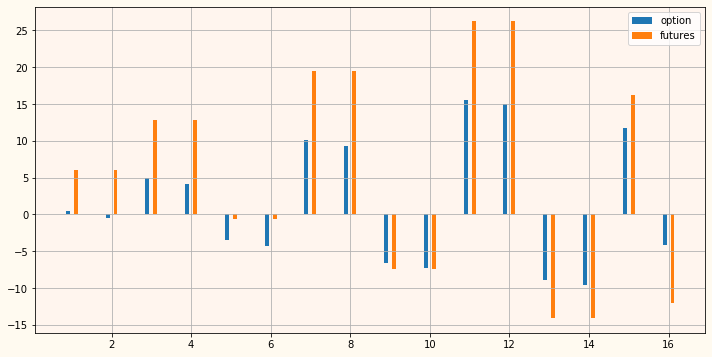

In [46]:
#В первый день соотношение цены фьючерса и опциона в 16 span сценариях
x1=np.arange(1,len(option_scenarios[0])+1)-0.1
x2=np.arange(1,len(option_scenarios[0])+1)+0.1
fig, ax = plt.subplots()

ax.bar(x1, option_scenarios[0], width = 0.1, label='option')
ax.bar(x2, futures_scenarios[0], width = 0.1,label='futures')

ax.set_facecolor('seashell')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor('floralwhite')
plt.legend()
plt.grid()
plt.show()


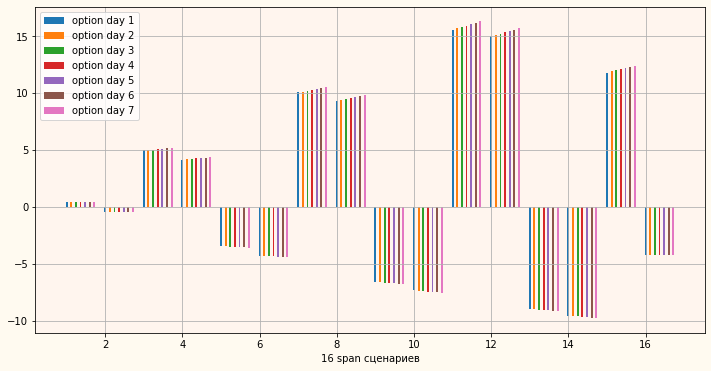

In [47]:
#16 сценариев. Range для каждого сценария увеличивается на каждый день.
x = np.arange(1,len(option_scenarios[0])+1)
fig, ax = plt.subplots()
message='option day {day_number}'
for i in range(0,len(option_scenarios)):
    ax.bar(x+0.12*i, option_scenarios[i], width = 0.05, label=message.format(day_number=i+1))


ax.set_facecolor('seashell')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor('floralwhite')
ax.set_xlabel('16 span сценариев')
plt.legend()
plt.grid()
plt.show()

In [24]:
option_change(55, 50, 0.25, 60/365, 0.2, 0.2, put=False)[2]

[6.8232748740123625,
 5.000000270046428,
 9.700631585867335,
 8.666666666666664,
 4.387552899645488,
 1.3802693741103909,
 12.893407732606896,
 12.333333333333329,
 2.503538532550653,
 0.0030581161574395055,
 16.291405391904462,
 16.0,
 1.2184885975545736,
 2.063448958317387e-11,
 27.000013752588515,
 1.882991030878131e-05]

In [25]:
option_price_share(50, 45, 0.2, 60/365, put=False)

5.175268004231242

In [26]:
option_price_share(50, 45, 0.3, 60/365, put=False)

5.615511516265357

In [17]:
contract_p

[[100,
  121.0,
  122.41421356237309,
  124.14626436994199,
  100,
  43.23533530511647,
  100],
 [120.0,
  100,
  100,
  124.14626436994199,
  126.14626436994199,
  43.23533530511647,
  100],
 [120.0,
  121.0,
  100,
  124.14626436994199,
  126.14626436994199,
  43.23533530511647,
  100],
 [120.0, 121.0, 100, 100, 126.14626436994199, 43.23533530511647, 100],
 [100,
  121.0,
  122.41421356237309,
  100,
  126.14626436994199,
  43.23533530511647,
  100],
 [100,
  121.0,
  122.41421356237309,
  124.14626436994199,
  126.14626436994199,
  43.23533530511647,
  100],
 [100,
  100,
  122.41421356237309,
  124.14626436994199,
  126.14626436994199,
  43.23533530511647,
  100],
 [120.0,
  100,
  122.41421356237309,
  124.14626436994199,
  100,
  43.23533530511647,
  100],
 [120.0, 121.0, 100, 124.14626436994199, 100, 43.23533530511647, 100],
 [120.0, 121.0, 122.41421356237309, 100, 100, 43.23533530511647, 100],
 [120.0,
  100,
  122.41421356237309,
  124.14626436994199,
  126.14626436994199,
  4

In [19]:
futures_p

[[6.180108953081259,
  26.21383444073882,
  26.26923716296035,
  26.341272552014672,
  6.1056191665625335,
  -12.176680311171387,
  6.068352097857996],
 [26.18010895308126,
  6.161492048479801,
  6.142871449681564,
  26.341272552014672,
  26.427329347141693,
  -12.176680311171387,
  6.068352097857996],
 [26.18010895308126,
  26.21383444073882,
  6.142871449681564,
  26.341272552014672,
  26.427329347141693,
  -12.176680311171387,
  6.068352097857996],
 [26.18010895308126,
  26.21383444073882,
  6.142871449681564,
  6.1242471559535545,
  26.427329347141693,
  -12.176680311171387,
  6.068352097857996],
 [6.180108953081259,
  26.21383444073882,
  26.26923716296035,
  6.1242471559535545,
  26.427329347141693,
  -12.176680311171387,
  6.068352097857996],
 [6.180108953081259,
  26.21383444073882,
  26.26923716296035,
  26.341272552014672,
  26.427329347141693,
  -12.176680311171387,
  6.068352097857996],
 [6.180108953081259,
  6.161492048479801,
  26.26923716296035,
  26.341272552014672,
  2

In [37]:
collateral

[[0.0,
  -13580.746024239901,
  -14278.542506027328,
  -15135.255762947772,
  0.0,
  -13126.828097754782,
  0.0],
 [-13090.05447654063,
  0.0,
  0.0,
  -15135.255762947772,
  -16125.941768252262,
  -13126.828097754782,
  0.0],
 [-13090.05447654063,
  -13580.746024239901,
  0.0,
  -15135.255762947772,
  -16125.941768252262,
  -23040.59687742639,
  0.0],
 [-13090.05447654063,
  -13580.746024239901,
  0.0,
  0.0,
  -16125.941768252262,
  -13126.828097754782,
  0.0],
 [0.0,
  -13580.746024239901,
  -14278.542506027328,
  0.0,
  -16125.941768252262,
  -13126.828097754782,
  0.0],
 [0.0,
  -13580.746024239901,
  -14278.542506027328,
  -15135.255762947772,
  -16125.941768252262,
  -23040.59687742639,
  0.0],
 [0.0,
  0.0,
  -14278.542506027328,
  -15135.255762947772,
  -16125.941768252262,
  -13126.828097754782,
  0.0],
 [-13090.05447654063,
  0.0,
  -14278.542506027328,
  -15135.255762947772,
  0.0,
  -13126.828097754782,
  0.0],
 [-13090.05447654063,
  -13580.746024239901,
  0.0,
  -15135.2

In [17]:
#Для каждой стратегии закрытия находим стоимость портфеля суммарную в течение 7 дней
cum_coll=list(map(lambda x: sum(x),collateral))

In [18]:
cum_coll

[-51480.11843981898,
 -51542.30178808087,
 -71825.10093195034,
 -51478.58273244295,
 -51523.14683738249,
 -71869.66503688987,
 -51586.86589302042,
 -51463.2556959902,
 -51435.55433487944,
 -51399.53664035227,
 -71852.8022930611,
 -51506.28409355371,
 -71789.08323742317,
 -51559.16453190965,
 -71746.05483985966]

In [19]:
#Конвертируем в array для удобства
close_strategy=np.array(sale_fut)
#Делаем кумулятивную сумму для каждого элемента списка объема форвардных позиций
close_strategy_cum=list(map(lambda x: (x.cumsum())/7,close_strategy))
#Суммируем эти кумулятивные элементы
close_strategy_sum=list(map(lambda x: sum(x),close_strategy_cum))

In [20]:
table=pd.DataFrame(columns=['scenario','collateral'])
table['scenario']=close_strategy_sum
table['collateral']=cum_coll
sort_table=table.sort_values(['scenario'],ascending=[1])
sort_table.index = np.arange(len(sort_table))

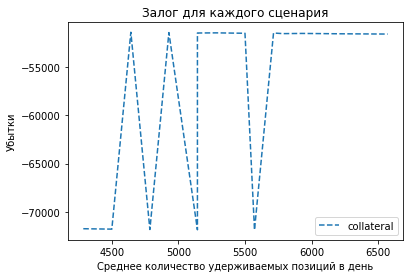

In [21]:
plt.plot(sort_table['scenario'], sort_table['collateral'], '--', label='collateral')
plt.title('Залог для каждого сценария')
plt.ylabel('Убытки')
plt.xlabel('Среднее количество удерживаемых позиций в день') #средняя позиция к риску
plt.legend()
plt.show()
#Чем больше показатель по оси x, тем дольше удерживаем форвардные контракты в портфеле

In [20]:
#Для отрисовки P&L портфеля в день исполнения

#Функции для расчета цены фьючерса на 1 день
def future_const_long(price,strike,time,r):
    future_price=price-strike*(math.exp(-time*r))
    return future_price

def future_const_short(price,strike,time,r):
    future_price=-(price-strike*(math.exp(-time*r)))
    return future_price

In [21]:
#Для построения графика создаем range спотовых цен
spot= np.arange(1, 31, 0.1)
#Список страйков на каждый день
K=15*np.ones(len(spot))
#Отрисовка в день исполнения
time=(0/252)*np.ones(len(spot))
#Вектор ставок
r=0.05*np.ones(len(spot))

#Список цен фьючерсов в зависимости от спотовой цены
fut_price_short=list(map(future_const_short,spot,K,time,r))

In [22]:
IV=0.25*np.ones(len(spot))
time0=np.zeros(len(spot))
r=0.05*np.ones(len(spot))
call_price_cont=list(map(option_price_share,spot,K,IV,time0,r))

C:\Users\800G1\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


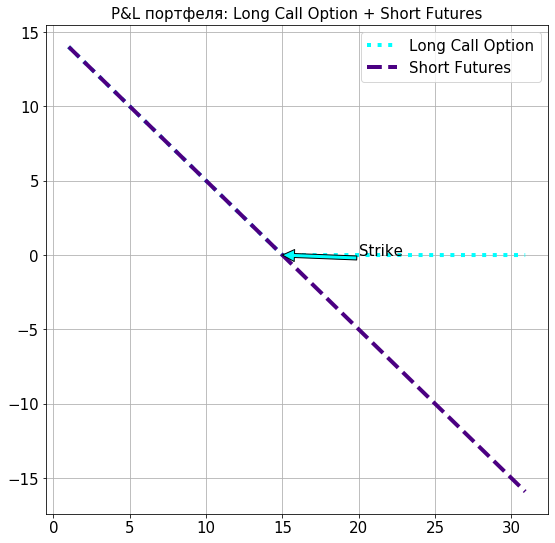

In [23]:
plt.figure(figsize=(9,9))

plt.plot(spot, call_price_cont, ':',color='aqua',linewidth=4,label='Long Call Option')
plt.plot(spot, fut_price_short, '--',color='indigo',linewidth=4, label='Short Futures')
plt.title('P&L портфеля: Long Call Option + Short Futures',fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(labelsize=15)
plt.annotate('Strike',fontsize=15, xy=(15, 0),  xycoords='data',
            xytext=(20, 0), textcoords='data',
            arrowprops=dict(facecolor='aqua'))
plt.grid()

plt.show()